# PortfolioOptimiser.jl

This is a demo for getting started with `PortfolioOptimiser.jl`.

In [103]:
using PortfolioOptimiser
using CSV, DataFrames, Plots, CovarianceEstimation, LinearAlgebra, Statistics, MarketData, JuMP

## Loading data

All our functions take AbstractArray or Tuple arguments, not DataFrame or TimeArray data. The reason is to keep the code as generic and performant as possible. Julia is fast enough that it can be used in performance critical applications, so we remove the data wrangling from the equation, and we leave it up to the user to decide how they want to handle their data.

For the example we'll use CSV and DataFrames to load our historical prices. 

We have the data in the `assets` folder, but the package [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl) can be used to download stock data.

In [104]:
hist_prices = CSV.read("./assets/stock_prices.csv", DataFrame)
dropmissing!(hist_prices)

896×21 DataFrame
 Row │ date        GOOG      AAPL      FB       BABA     AMZN     GE       AMD ⋯
     │ Date        Float64   Float64   Float64  Float64  Float64  Float64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2014-09-19   592.82    94.7721    77.91    93.89   331.32  23.421       ⋯
   2 │ 2014-09-22   584.158   94.866     76.8     89.89   324.5   23.2339
   3 │ 2014-09-23   577.952   96.3492    78.29    87.17   323.63  23.1805
   4 │ 2014-09-24   584.775   95.5137    78.54    90.57   328.21  23.1003
   5 │ 2014-09-25   571.915   91.8715    77.22    88.92   321.93  22.7618      ⋯
   6 │ 2014-09-26   573.944   94.575     78.79    90.46   323.21  22.833
   7 │ 2014-09-29   573.208   93.9743    79.0     88.75   321.82  22.646
   8 │ 2014-09-30   574.203   94.575     79.04    88.85   322.44  22.8241
  ⋮  │     ⋮          ⋮         ⋮         ⋮        ⋮        ⋮        ⋮         ⋱
 890 │ 2018-04-03  1013.41   168.39     156.11   174.67  1392.05  13.13        ⋯
 891 │ 2018-04-04  1025.14   171.61     155.1    172.07  1410.57  13.28
 892 │ 2018-04-05  1027.81   172.8      159.34   172.57  1451.75  13.43      1
 893 │ 2018-04-06  1007.04   168.38     157.2    167.52  1405.23  13.06
 894 │ 2018-04-09  1015.45   170.05     157.93   169.87  1406.08  12.83        ⋯
 895 │ 2018-04-10  1031.64   173.25     165.04   177.1   1436.22  13.05
 896 │ 2018-04-11  1019.97   172.44     166.32   175.36  1427.05  12.97
                                                 14 columns and 881 rows omitted

## Returns

`PortfolioOptimiser.jl` calculates a variety of returns and expected returns from the historical price data. Here we use daily prices, but we can use any price frequency. When using other price frequencies, you should adjust the `freq` parameters in the corresponding functions.

We can get both regular and log returns with the function `returns_from_prices`. 

Log returns are useful because they can be added instead of multiplied when compounding, however the function defaults to regular returns.

In [105]:
returns = returns_from_prices(hist_prices[!, 2:end])
log_returns = returns_from_prices(hist_prices[!, 2:end], true)
exp.(log_returns) .- 1 ≈ returns

true

We can also recover relative prices from the returns. Since DataFrames does not define `cumprod` we must use arrays.

In [106]:
rel_prices = prices_from_returns(Matrix(returns[!, :]))
rel_prices_log = prices_from_returns(Matrix(log_returns[!, :]), true)
rel_prices ≈ rel_prices_log

true

We can reconstruct the original prices by multiplying the first entry of historical prices by the corresponding relative prices.

In [107]:
reconstructed_prices = (rel_prices' .* Vector(hist_prices[1, 2:end]))'
reconstructed_prices ≈ Matrix(hist_prices[!, 2:end])

true

## Expected returns

We have a few ways of calculating a variety of expected/mean returns:

- arithmetic mean
- exponentially weighted mean
- capital asset pricing model
- exponentially weighted capital asset pricing model

The optional keyword arguments are further explained in the docs.

Typically, exponentially-weighted returns are more predictive of future returns, as they assign higher weights to more recent values. 

The CAPM is a more stable return measure because it accounts for the return value, covariance to other assets, covariance to the market, and risk free rate. The exponential version simply uses exponential returns to calculate the mean market return. When you don't provide a vector of market returns to the CAPM models (which is the case here), they are calculated as the mean of the returns of the assets provided.

In [108]:
# Number of rows and columns for calculating the exponential weights.
num_rows = nrow(returns)
num_cols = ncol(returns)

# Split the returns 
past_returns = Matrix(returns[1:div(num_rows, 2), :])
future_returns = Matrix(returns[(div(num_rows, 2)+1):end, :])

# Arithmetic future returns.
mean_future_rets = ret_model(MRet(), future_returns)

# Various past mean returns.
mean_ret = ret_model(MRet(), past_returns)
e_mean_ret = ret_model(EMRet(), past_returns, span = num_rows / 2)
capm_ret = ret_model(CAPMRet(), past_returns)
e_capm_ret = ret_model(ECAPMRet(), past_returns, cspan = num_rows / 2, rspan = num_rows / 2)

DataFrame(future = mean_future_rets, mean = mean_ret, emean = e_mean_ret, capm = capm_ret, ecapm = e_capm_ret)

┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30
┌ Warning: Covariance matrix is not positive definite. Fixing eigenvalues.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:23
┌ Warning: Covariance matrix could not be fixed. Try a different risk model.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\RiskModels\RiskModelsUtil.jl:30


20×5 DataFrame
 Row │ future      mean         emean       capm       ecapm     
     │ Float64     Float64      Float64     Float64    Float64   
─────┼───────────────────────────────────────────────────────────
   1 │  0.251907    0.084095     0.103919   0.0733891  0.113483
   2 │  0.42774    -0.0192506   -0.105036   0.0775557  0.125335
   3 │  0.235747    0.240336     0.305976   0.0816804  0.132916
   4 │  0.576821   -0.0989912    0.0241145  0.0865019  0.146773
   5 │  0.474416    0.543596     0.650579   0.0862735  0.139536
   6 │ -0.362388    0.125079     0.176711   0.0712196  0.116269
   7 │  0.44086     0.182588     2.02136    0.142432   0.292654
   8 │  0.12899    -0.00619495   0.102599   0.0519984  0.0759931
  ⋮  │     ⋮            ⋮           ⋮           ⋮          ⋮
  14 │ -0.0613527   0.00517498   0.173752   0.071053   0.111996
  15 │ -0.452307   -0.237187     0.313945   0.108906   0.202122
  16 │  0.648166   -0.0427683   -0.0113388  0.083751   0.129529
  17 │  0.433993    0.112071     0.0620492  0.0803037  0.133447
  18 │  0.050772    0.120351     0.169813   0.0586689  0.0895488
  19 │  0.433141    0.0280035    0.0398924  0.0883728  0.156522
  20 │  0.0448829   0.275368     0.159749   0.0732492  0.118288
                                                   5 rows omitted

Note how there are warnings regarding the covariance matrix not being positive definite. These are from the CAPM returns, as they use the asset covariance with respect to the market returns. 

Using [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl) and `CustomCov()` or `CustomSCov()` (see Risk Models section) via the `cov_type` keyword argument, we can use a more robust covariance measurement for the CAPM returns

Downside risk tends to be more stable, to prove this we use both the shrunken covariance and shrunken semicovariance. 

Note that we can use any covariance estimator as defined by `cov` from `Statistics` or `StatsBase` by simply providing it via the `custom_cov_estimator` keyword argument. The default is to use the sample covariance for `CAPMRet()`, and exponentially weighted covariance for `ECAPMRet()`.

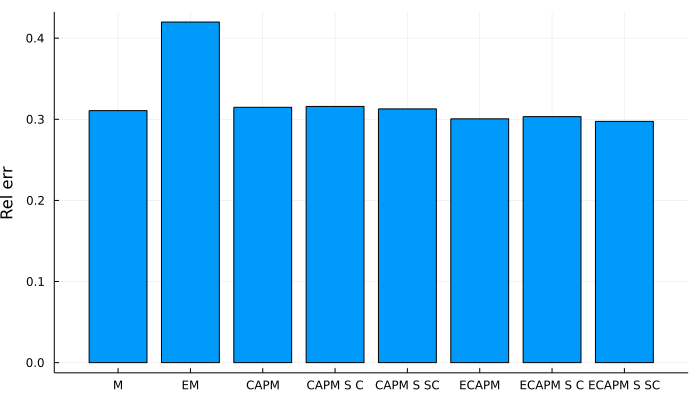

[0.31063526256932866, 0.419903378509077, 0.31474257003293027, 0.31587044704120426, 0.31284742055462733, 0.30055327745082006, 0.30327567778804315, 0.29747040200051755]


In [109]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

capm_ret_shrunken_cov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_cov = ret_model(
    ECAPMRet(),
    past_returns,
    cspan=num_rows / 2,
    rspan=num_rows / 2,
    cov_type=CustomCov(),
    custom_cov_estimator=method,
)

capm_ret_shrunken_scov = ret_model(
    CAPMRet(),
    past_returns,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

e_capm_ret_shrunken_scov = ret_model(
    ECAPMRet(),
    past_returns,
    cspan=num_rows / 2,
    rspan=num_rows / 2,
    cov_type=CustomSCov(),
    custom_cov_estimator=method,
)

errors = Float64[]
push!(errors, sum(abs.(mean_future_rets - mean_ret)))
push!(errors, sum(abs.(mean_future_rets - e_mean_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - capm_ret_shrunken_scov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_cov)))
push!(errors, sum(abs.(mean_future_rets - e_capm_ret_shrunken_scov)))

errors /= length(mean_future_rets)

fig = plot(
    ["M", "EM", "CAPM", "CAPM S C", "CAPM S SC", "ECAPM", "ECAPM S C", "ECAPM S SC"],
    errors,
    ylabel="Rel err",
    legend=false,
    size=(700, 400),
    seriestype=:bar,
)

display(fig)

println(errors)

Returns are chaotic and unpredictable, so it's often better to optimise portfolios without considering them. The average absolute errors are all over 30 %, so for this case, a portfolio that has an expected return of 10 %, will most likely return between [-20, 40] %.

Minimum variance, semivariance, CVaR and CDaR tend to give more stable portfolios than ones that take returns into consideration.

We can plot all the return types together to see how they correlate to each other.

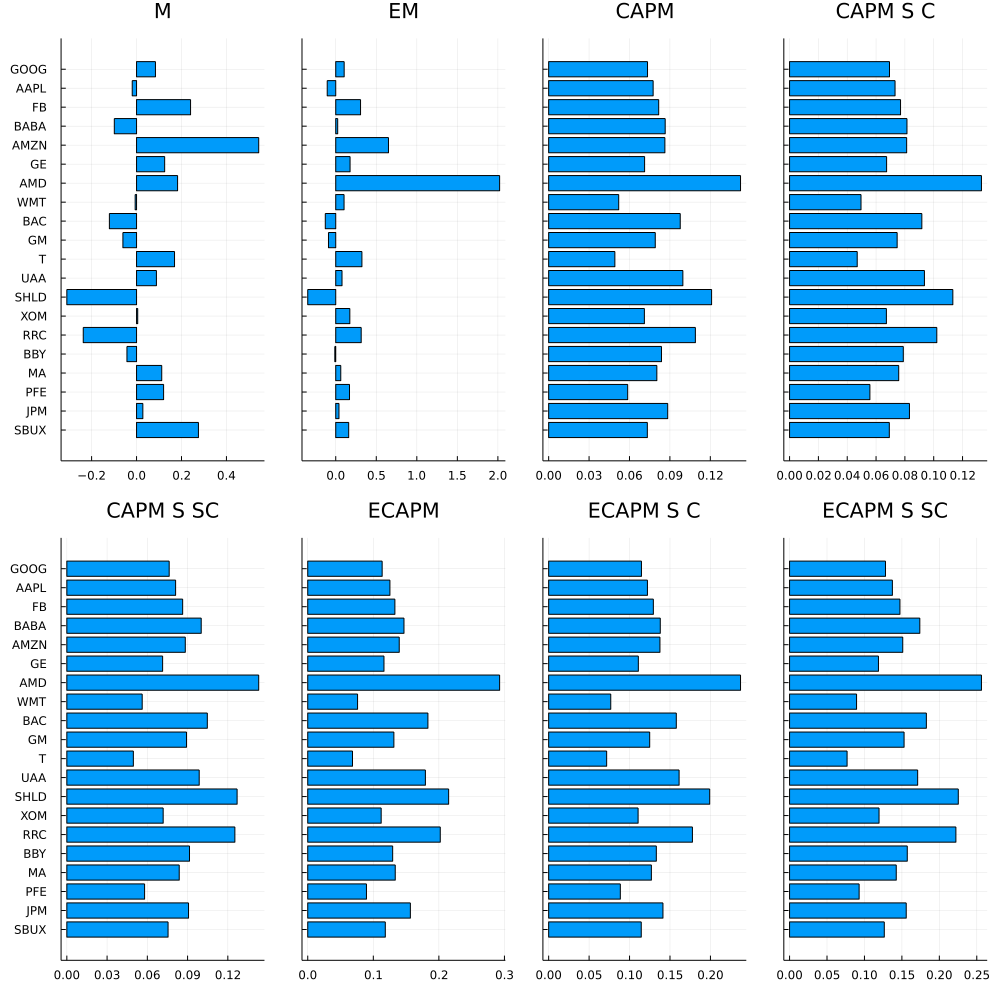

In [110]:
l = @layout [a b c d; e f g h]

fig1 = bar(
    mean_ret,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "M",
)

fig2 = bar(
    e_mean_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "EM",
)

fig3 = bar(
    capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM",
)

fig4 = bar(
    capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S C",
)

fig5 = bar(
    capm_ret_shrunken_scov,
    yticks = (1:num_cols, names(returns)),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "CAPM S SC",
)

fig6 = bar(
    e_capm_ret,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM",
)

fig7 = bar(
    e_capm_ret_shrunken_cov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S C",
)

fig8 = bar(
    e_capm_ret_shrunken_scov,
    yticks = (1:num_cols, []),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "ECAPM S SC",
)

plot(fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, layout = l, size = (1000, 1000))

There's strong correspondence between exponential and non-exponentially weighted return types. CAPM returns are a little bit different as they account for an asset's relationship to the market via a covariance matrix.

## Risk models

We also have a few built-in risk models. However, using CustomCov() and CustomSCov() we can make use of other models, such as those found in [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl), and use other types of weights other than exponential ones.

We provide a variety of covariance measures:

- sample covariance
- exponentially weighted sample covariance
- semicovariance
- exponentially weighted semicovariance
- custom covariance
- custom semicovariance

The optional keyword arguments are further explained in the docs.

We can see which covariance matrix estimates the future asset variances the best.

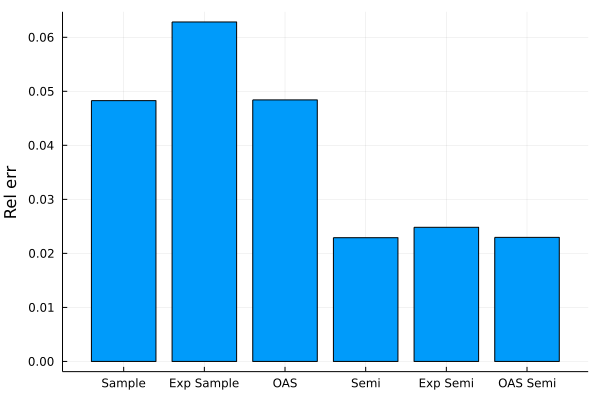

[0.04827333795084753, 0.0628297583608334, 0.04840679544002764, 0.022906141382702475, 0.024828750906271832, 0.022958747397658408]


In [111]:
future_cov = cov(Cov(), future_returns)
future_semi_cov = cov(SCov(), future_returns)

sample_cov = cov(Cov(), past_returns)
e_cov = cov(ECov(), past_returns, span = num_rows / 2)
semi_cov = cov(SCov(), past_returns)
e_semi_cov = cov(ESCov(), past_returns, span = num_rows / 2)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

oas_shrunken_cov = Matrix(cov(CustomCov(), past_returns, estimator = method))
oas_shrunken_cov_semi_cov = Matrix(cov(CustomSCov(), past_returns, estimator = method))

future_var = diag(future_cov)
future_semivar = diag(future_semi_cov)

errors = Float64[]
push!(errors, sum(abs.(future_var - diag(sample_cov))))
push!(errors, sum(abs.(future_var - diag(e_cov))))
push!(errors, sum(abs.(future_var - diag(oas_shrunken_cov))))
push!(errors, sum(abs.(future_semivar - diag(semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(e_semi_cov))))
push!(errors, sum(abs.(future_semivar - diag(oas_shrunken_cov_semi_cov))))

errors /= length(future_var)

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel = "Rel err",
    legend = false,
)

display(fig)

println(errors)

This is a toss up, as the non exponentially weighted covariances did a better job of estimating the correlations between assets than the corresponding exponentially weighted ones. However, shrunken covariances are made to be more stable, so they should be the default choice for long-term investments.

Furthermore, this lends more weight to the concept of using optimisations which account for downside risk such as EffMeanSemivar, CVaR and CDaR optimisations, and using the semicovariance as the input covariance matrix for Black-Litterman and Hierarchical Risk Parity optimisations.

We can do the same for the entire covariance matrix too, which is what the optimisations actually use.

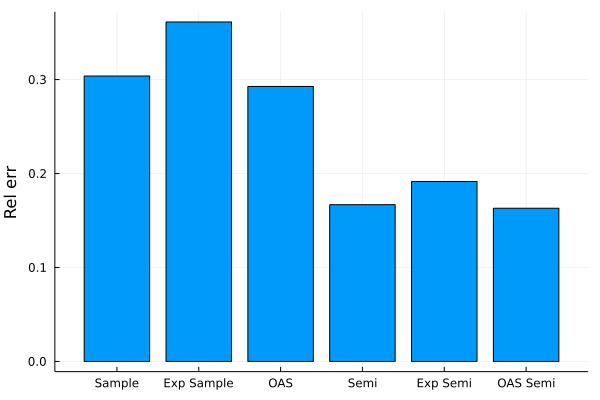

[0.30378672393598116, 0.36131776982053404, 0.29275023859924537, 0.16685498155701559, 0.19155746534756515, 0.1630895155655444]


In [112]:
errors = Float64[]
push!(errors, sum(abs.(future_cov - sample_cov)))
push!(errors, sum(abs.(future_cov - e_cov)))
push!(errors, sum(abs.(future_cov - oas_shrunken_cov)))
push!(errors, sum(abs.(future_semi_cov - semi_cov)))
push!(errors, sum(abs.(future_semi_cov - e_semi_cov)))
push!(errors, sum(abs.(future_semi_cov - oas_shrunken_cov_semi_cov)))

errors /= length(future_var)

fig = bar(
    ["Sample", "Exp Sample", "OAS", "Semi", "Exp Semi", "OAS Semi"],
    errors,
    ylabel = "Rel err",
    legend = false,
)

display(fig)

println(errors)

Again, this is a bit of a toss up between choosing exponentially weighted vs not, but the estimation error is again lower when using semicovariances.

If we plot the absolute percentage errors of the correlation matrices we can see that the semicovariance is a more stable measure of the correlation between assets, as evidenced by how much darker the second plot is compared to the first.

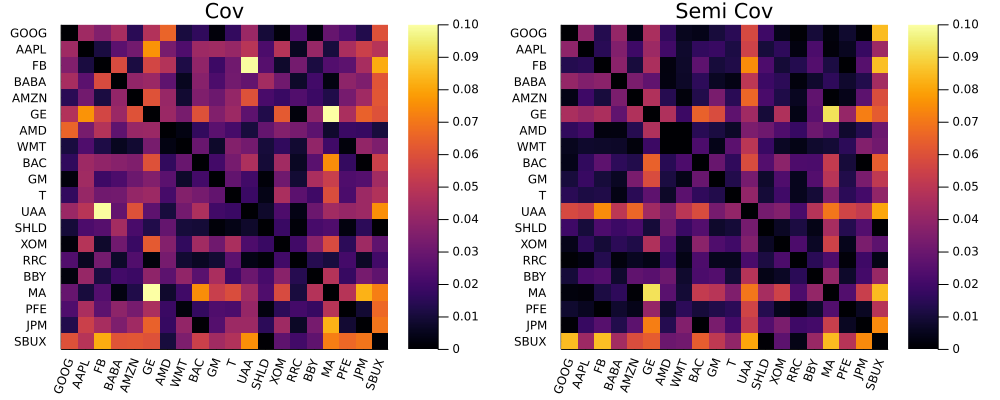

In [113]:
fig1 = heatmap(
    abs.(cov2cor(future_cov) - cov2cor(sample_cov)) / length(future_cov) * 100,
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-1),
    title = "Cov"
)

fig2 = heatmap(
    abs.(cov2cor(future_semi_cov) - cov2cor(semi_cov)) / length(future_semi_cov) * 100,
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    clims = (0, 1e-1),
    title = "Semi Cov"
)

plot(fig1, fig2, size = (1000, 400), bottom_margin = 5Plots.mm)

## Downloading data

In this section we show how we can use [`MarketData.jl`](https://github.com/JuliaQuant/MarketData.jl) to download stock data, [`TimeSeries.jl`](https://github.com/JuliaStats/TimeSeries.jl) to select only the closing prices and [`DataFrames.jl`](https://dataframes.juliadata.org/stable/) for plotting and other manipulation.

You can acquire lists of stocks from publicly available sources like the NASDAQ website, but we'll just provide a list of trendy stocks.

In [114]:
tickers = [
    "ACN",
    "AMZN",
    "COST",
    "DIS",
    "F",
    "GILD",
    "GME",
    "JPM",
    "KO",
    "LUV",
    "MA",
    "MSFT",
    "PFE",
    "TSLA",
    "UNH",
    "XOM",
];


In [115]:
# Download from yahoo, see the docs for MarketData.
data = yahoo.(tickers)

16-element Vector{TimeArray{Float64, 2, Date, Matrix{Float64}}}:
 5263×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2001-07-19 to 2022-06-17
 6316×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1997-05-15 to 2022-06-17
 9061×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1986-07-09 to 2022-06-17
 12955×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1971-02-08 to 2022-06-17
 12622×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1972-06-01 to 2022-06-17
 7660×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1992-01-22 to 2022-06-17
 5123×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2002-02-13 to 2022-06-17
 10656×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1980-03-17 to 2022-06-17
 12955×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1971-02-08 to 2022-06-17
 10708×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1980-01-02 to 2022-06-17
 4045×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2006-05-25 to 2022-06-17
 9142×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1986-03-13 to 2022-

In [116]:
# Merge only on the close data, see the docs for TimeSeries.
hist_prices = merge([data[i][:Close] for i in 1:length(data)]...)
# Convert to a DataFrame.
hist_prices = DataFrames.rename(DataFrame(hist_prices), ["timestamp"; tickers])

3015×17 DataFrame
  Row │ timestamp   ACN      AMZN      COST     DIS      F        GILD     GME ⋯
      │ Date        Float64  Float64   Float64  Float64  Float64  Float64  Flo ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 2010-06-29    38.65    5.4305    55.63    32.3      9.88   17.485    1 ⋯
    2 │ 2010-06-30    38.65    5.463     54.83    31.5     10.08   17.14     1
    3 │ 2010-07-01    38.28    5.548     54.9     31.49    10.57   17.07     1
    4 │ 2010-07-02    37.94    5.457     54.23    31.38    10.28   17.435    1
    5 │ 2010-07-06    38.41    5.503     54.0     31.72    10.16   17.385    1 ⋯
    6 │ 2010-07-07    39.26    5.6715    54.29    33.14    10.59   17.47     1
    7 │ 2010-07-08    39.34    5.811     55.71    33.34    10.62   17.41     1
    8 │ 2010-07-09    39.42    5.863     56.19    33.75    10.85   17.37     1
  ⋮   │     ⋮          ⋮        ⋮         ⋮        ⋮        ⋮        ⋮         ⋱
 3009 │ 2022-06-09   295.43  116.15     472.05   103.3     13.28   61.18    12 ⋯
 3010 │ 2022-06-10   286.01  109.65     463.31    99.4     12.75   60.74    12
 3011 │ 2022-06-13   276.5   103.67     452.25    95.71    11.81   59.15    11
 3012 │ 2022-06-14   275.12  102.31     454.8     94.22    12.2    57.79    12
 3013 │ 2022-06-15   281.19  107.67     458.79    95.88    12.27   58.39    12 ⋯
 3014 │ 2022-06-16   270.9   103.66     451.76    94.28    11.25   57.72    12
 3015 │ 2022-06-17   275.38  106.22     446.69    94.34    11.23   58.53    13
                                                10 columns and 3000 rows omitted

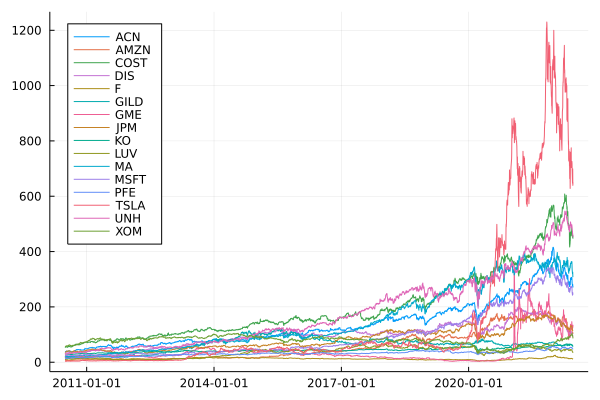

In [117]:
# Plot ticker closing prices.
fig = plot()
for ticker in tickers
    plot!(fig, hist_prices[!, 1], hist_prices[!, ticker], label=ticker)
end
plot(fig, legend=:topleft)

As previously stated, it's best to use a more stable measure of covariance other than the sample covariance matrix. The sample covariance can be subject to noise, particularly if the number of variables is greater than the number of observations. Furthermore, it can be sensitive to extreme outlier observations. We can avoid these by using a more sophisticated estimation of the covariance matrix.

The package [CovarianceEstimation.jl](https://github.com/mateuszbaran/CovarianceEstimation.jl) implements methods to estimate more robust measures of the covariance, of which we make ample use.

`PortfolioOptimiser.jl` extends the definition of `Statistics.cov` (see docs). Through the `CustomCov()` struct, we can use any custom covariance estimator defined by other packages.

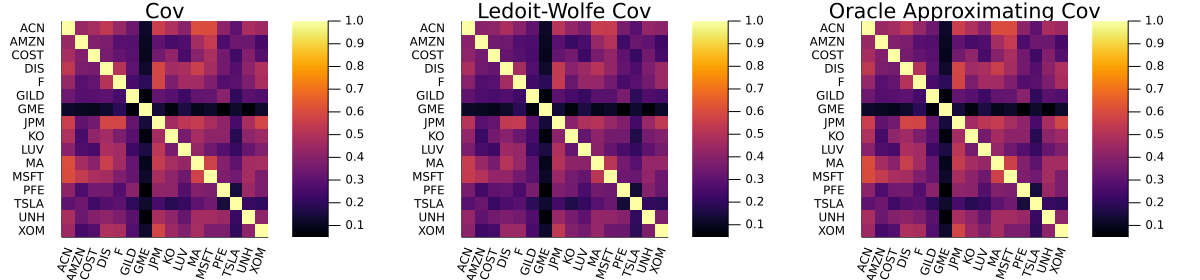

In [118]:
l = @layout [a b c]

returns = returns_from_prices(hist_prices[!, 2:end])
num_cols = ncol(returns)
num_rows = nrow(returns)

S = cov(Cov(), Matrix(returns), freq = 252)

fig1 = heatmap(
    cov2cor(S),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    title = "Cov"
)

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator=method)

fig2 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Ledoit-Wolfe Cov"
)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator=method)

fig3 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Oracle Approximating Cov"
)

plot(fig1, fig2, fig3, size=(1200, 280), bottom_margin = 5Plots.mm, layout = l)

The `cov` functions defined in `PortfolioOptimiser.jl`, also provide a way to use any covariance estimator on the semicovariance, via the `CustomSCov()` struct as the following code block shows.

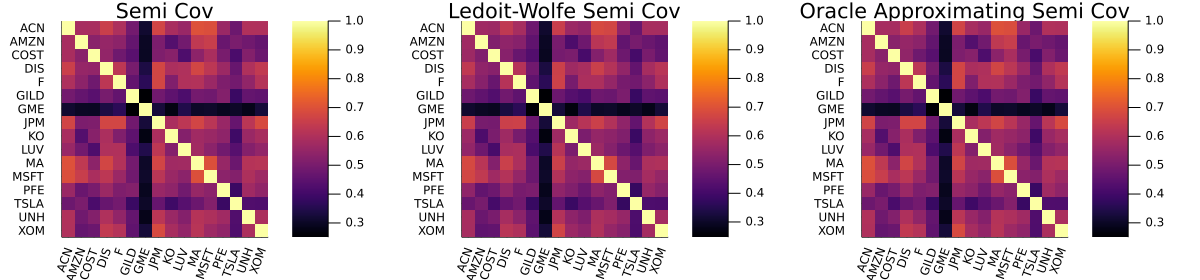

In [119]:
l = @layout [a b c]

returns = returns_from_prices(hist_prices[!, 2:end])
num_cols = ncol(returns)
num_rows = nrow(returns)

S = cov(SCov(), Matrix(returns), freq = 252)

fig1 = heatmap(
    cov2cor(S),
    yflip = true,
    xticks = (1:num_cols, names(returns)),
    yticks = (1:num_cols, names(returns)),
    xrotation = 70,
    title = "Semi Cov"
)

target = DiagonalCommonVariance()
shrinkage = :lw
method = LinearShrinkage(target, shrinkage)

S = cov(CustomSCov(), Matrix(returns), estimator=method)

fig2 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Ledoit-Wolfe Semi Cov"
)

target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomSCov(), Matrix(returns), estimator=method)

fig3 = heatmap(
    cov2cor(Matrix(S)),
    yflip=true,
    xticks=(1:num_cols, names(returns)),
    yticks=(1:num_cols, names(returns)),
    xrotation=70,
    title = "Oracle Approximating Semi Cov"
)

plot(fig1, fig2, fig3, size=(1200, 280), bottom_margin = 5Plots.mm, layout = l)

# Efficient Frontier Optimisation

As previously stated, providing mean returns is not the best idea given how volatile they can be. Returns are optional on risk minimising portfolios `min_risk!`.

Every optimiser subtyped from `AbstractEfficient` has the following optimisation functions:

- `min_risk!`: minimises the risk measure.
- `max_sharpe!`: maximises `(return - rf)/risk`, where `rf` is the risk free rate. However, it's worth noting this uses a variable transformation to turn the non-convex optimisation problem into a convex one. If you want to use extra objective terms, you should use `custom_nloptimiser!` instead. More on that later.
- `max_utility!`: difference between the `return - l * risk`, where `l` is the risk aversion parameter divided by 2.
- `efficient_return!`: maximises the return with the constraint that the risk must be less than or equal to a specified value.
- `efficient_risk!`: minimises the risk with the constraint that the return must be equal to or greater than a specified value.

As we are demonstrating all optimisation functions, we will provide mean returns. However, we'll use exponentially weighted CAPM returns, with an adjusted covariance. All our covariances (full and semi) will be Oracle Approximating shrunken covariances. This should give us relatively robust measures of returns and risk, reducing the chance to overfit noise.

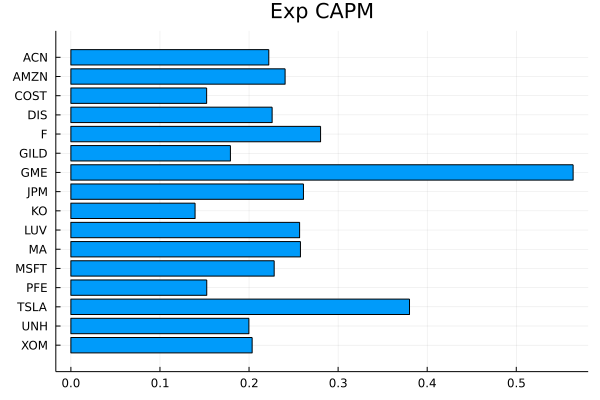

In [120]:
target = DiagonalCommonVariance()
shrinkage = :oas
method = LinearShrinkage(target, shrinkage)

S = cov(CustomCov(), Matrix(returns), estimator = method)

mean_ret = ret_model(
    ECAPMRet(),
    Matrix(returns),
    cspan = num_rows / 2,
    rspan = num_rows / 2,
    cov_type = CustomCov(),
    custom_cov_estimator = method,
)

fig = bar(
    mean_ret,
    yticks = (1:num_cols, tickers),
    orientation = :h,
    yflip = true,
    legend = false,
    title = "Exp CAPM",
)

## Mean Variance

These portfolios use the portfolio variance as their risk measure. We'll start off by showing the default behaviour before moving to more advanced features and customisation as we move along.

First, we create our instance of the efficient mean variance structure which contains all the data necessary for our optimisations. See the docs of `EffMeanVar` to see what the structure contains, and what the constructor does.

In [121]:
emv = EffMeanVar(tickers, mean_ret, S)

display(fieldnames(typeof(emv)))
methods(EffMeanVar)

(:tickers, :mean_ret, :weights, :cov_mtx, :rf, :market_neutral, :risk_aversion, :target_risk, :target_ret, :extra_vars, :extra_constraints, :extra_obj_terms, :model)

# 2 methods for type constructor:
[1] EffMeanVar(tickers, mean_ret, cov_mtx; weight_bounds, rf, market_neutral, risk_aversion, target_risk, target_ret, extra_vars, extra_constraints, extra_obj_terms) in PortfolioOptimiser at d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarType.jl:97
[2] EffMeanVar(tickers::T1, mean_ret::T2, weights::T3, cov_mtx::T4, rf::T5, market_neutral::T6, risk_aversion::T7, target_risk::T8, target_ret::T9, extra_vars::T10, extra_constraints::T11, extra_obj_terms::T12, model::T13) where {T1, T2, T3, T4, T5, T6, T7, T8, T9, T10, T11, T12, T13} in PortfolioOptimiser at d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\EfficientFrontierOptimiser\MeanVar\MeanVarType.jl:48

Crucially, all concrete `EfficientFrontier` types contain a `model` field which stores a `JuMP` model along with all the necesary `JuMP` variables and constraints, including a term for the return, `model[:ret]` (if `mean_ret` was provided), and risk, `model[:risk]`, measures. 

Currently, the return is the arithmetic return, but this may be expanded in the future to account for other return types such as kelly objectives. 

The risk measure is dependent on the concrete type of the optimiser.

We will expand on these features later.

In [122]:
display(emv.model)
# Portfolio return, dot(w, mean_ret).
display(emv.model[:ret])
# Portfolio risk, in this case this is the portfolio variance dot(w, S, w).
display(emv.model[:risk])
# Model formulation so far.
display(latex_formulation(emv.model))

A JuMP Model
Feasibility problem with:
Variables: 16
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1 constraint
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 16 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 16 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: lower_bounds, ret, risk, sum_w, upper_bounds, w

0.2221732029385564 w[1] + 0.24048721922607627 w[2] + 0.15240463013555336 w[3] + 0.22592717626861797 w[4] + 0.2803051590169262 w[5] + 0.17910082949575654 w[6] + 0.5638235677598518 w[7] + 0.26109195555358866 w[8] + 0.13941559815324306 w[9] + 0.25677202035122026 w[10] + 0.257709860393716 w[11] + 0.2282180943174643 w[12] + 0.15252680946285213 w[13] + 0.38014712673240386 w[14] + 0.19982560981796102 w[15] + 0.20349086433927738 w[16]

0.05790198197351091 w[1]² + 0.10356718764600892 w[2]² + 0.06797577946584865 w[2]*w[1] + 0.04130472269639423 w[3]² + 0.04590269494527245 w[3]*w[1] + 0.050390975615791644 w[3]*w[2] + 0.06433639966797791 w[4]² + 0.06466661103855609 w[4]*w[1] + 0.06027020608008174 w[4]*w[2] + 0.0369208416854052 w[4]*w[3] + 0.10936364475705247 w[5]² + 0.06884924905075092 w[5]*w[1] + 0.061529527999900434 w[5]*w[2] + 0.042102661574057273 w[5]*w[3] + 0.08423572152470508 w[5]*w[4] + 0.07864163419371625 w[6]² + 0.045300629446734735 w[6]*w[1] + 0.05069673394883314 w[6]*w[2] + 0.03261736908208302 w[6]*w[3] + 0.042389718505463046 w[6]*w[4] + 0.04612255495706285 w[6]*w[5] + 0.9313236072953675 w[7]² + 0.054645689379668155 w[7]*w[1] + 0.06575877412743103 w[7]*w[2] + 0.03795001406931654 w[7]*w[3] + 0.06035868814437116 w[7]*w[4] + 0.12180824279077716 w[7]*w[5] + 0.035737943526653056 w[7]*w[6] + 0.08068443730369128 w[8]² + 0.07619326887270482 w[8]*w[1] + 0.05630570440806091 w[8]*w[2] + 0.04022654157003625 w[8]*w[3] + 0.0

$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} + w_{6} + w_{7} + w_{8} + w_{9} + w_{10} + w_{11} + w_{12} + w_{13} + w_{14} + w_{15} + w_{16} = 1.0\\
 & w_{1} \geq 0.0\\
 & w_{2} \geq 0.0\\
 & w_{3} \geq 0.0\\
 & w_{4} \geq 0.0\\
 & w_{5} \geq 0.0\\
 & w_{6} \geq 0.0\\
 & w_{7} \geq 0.0\\
 & w_{8} \geq 0.0\\
 & w_{9} \geq 0.0\\
 & w_{10} \geq 0.0\\
 & w_{11} \geq 0.0\\
 & w_{12} \geq 0.0\\
 & w_{13} \geq 0.0\\
 & w_{14} \geq 0.0\\
 & w_{15} \geq 0.0\\
 & w_{16} \geq 0.0\\
 & w_{1} \leq 1.0\\
 & w_{2} \leq 1.0\\
 & w_{3} \leq 1.0\\
 & w_{4} \leq 1.0\\
 & w_{5} \leq 1.0\\
 & w_{6} \leq 1.0\\
 & w_{7} \leq 1.0\\
 & w_{8} \leq 1.0\\
 & w_{9} \leq 1.0\\
 & w_{10} \leq 1.0\\
 & w_{11} \leq 1.0\\
 & w_{12} \leq 1.0\\
 & w_{13} \leq 1.0\\
 & w_{14} \leq 1.0\\
 & w_{15} \leq 1.0\\
 & w_{16} \leq 1.0\\
\end{aligned} $$

We can use this to finish building the model and optimise for the minimum risk.

In [123]:
min_risk!(emv)

None of the optimisation functions return any values. The message that you see when running this comes from Ipopt. It only happens the first time `JuMP.optimize!` is called on a model which has Ipopt as its solver. We chose Ipopt as the default optimiser because it lets us minimise our dependancies because aside from mixed-integer optimisation, it can handle all the problem types we have to solve. This means we can provide defaults for all our functions whilst only having two optimisers as dependencies.

The default choice of optimiser can change in the future, but don't worry, you can choose any optimiser that is supported by [`JuMP`](https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers). Bare in mind, some optimisers have no default attributes, so you'll have to use the `optimiser_attributes` keyword argument.

We can see what the model looks like after being set up and optimised for the minimum risk. If you look closely, the function being minimised is the risk function.

In [124]:
display(latex_formulation(emv.model))
emv.model[:risk]

$$ \begin{aligned}
\min\quad & 0.05790198197351091 w_{1}^2 + 0.10356718764600892 w_{2}^2 + 0.06797577946584865 w_{2}\times w_{1} + 0.04130472269639423 w_{3}^2 + 0.04590269494527245 w_{3}\times w_{1} + 0.050390975615791644 w_{3}\times w_{2} + 0.06433639966797791 w_{4}^2 + 0.06466661103855609 w_{4}\times w_{1} + 0.06027020608008174 w_{4}\times w_{2} + 0.0369208416854052 w_{4}\times w_{3} + 0.10936364475705247 w_{5}^2 + 0.06884924905075092 w_{5}\times w_{1} + 0.061529527999900434 w_{5}\times w_{2} + 0.042102661574057273 w_{5}\times w_{3} + 0.08423572152470508 w_{5}\times w_{4} + 0.07864163419371625 w_{6}^2 + 0.045300629446734735 w_{6}\times w_{1} + 0.05069673394883314 w_{6}\times w_{2} + 0.03261736908208302 w_{6}\times w_{3} + 0.042389718505463046 w_{6}\times w_{4} + 0.04612255495706285 w_{6}\times w_{5} + 0.9313236072953675 w_{7}^2 + 0.054645689379668155 w_{7}\times w_{1} + 0.06575877412743103 w_{7}\times w_{2} + 0.03795001406931654 w_{7}\times w_{3} + 0.06035868814437116 w_{7}\times w_{

0.05790198197351091 w[1]² + 0.10356718764600892 w[2]² + 0.06797577946584865 w[2]*w[1] + 0.04130472269639423 w[3]² + 0.04590269494527245 w[3]*w[1] + 0.050390975615791644 w[3]*w[2] + 0.06433639966797791 w[4]² + 0.06466661103855609 w[4]*w[1] + 0.06027020608008174 w[4]*w[2] + 0.0369208416854052 w[4]*w[3] + 0.10936364475705247 w[5]² + 0.06884924905075092 w[5]*w[1] + 0.061529527999900434 w[5]*w[2] + 0.042102661574057273 w[5]*w[3] + 0.08423572152470508 w[5]*w[4] + 0.07864163419371625 w[6]² + 0.045300629446734735 w[6]*w[1] + 0.05069673394883314 w[6]*w[2] + 0.03261736908208302 w[6]*w[3] + 0.042389718505463046 w[6]*w[4] + 0.04612255495706285 w[6]*w[5] + 0.9313236072953675 w[7]² + 0.054645689379668155 w[7]*w[1] + 0.06575877412743103 w[7]*w[2] + 0.03795001406931654 w[7]*w[3] + 0.06035868814437116 w[7]*w[4] + 0.12180824279077716 w[7]*w[5] + 0.035737943526653056 w[7]*w[6] + 0.08068443730369128 w[8]² + 0.07619326887270482 w[8]*w[1] + 0.05630570440806091 w[8]*w[2] + 0.04022654157003625 w[8]*w[3] + 0.0

We can check the portfolio performance, and see the weights given to each ticker. As you can see, both `TSLA` and `GME` are quite low, so this optimisation has big 🧻🙌 energy.

In [125]:
mu, sigma, sr = portfolio_performance(emv, verbose=true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.0 %
Annual volatility: 14.75 %
Sharpe Ratio: 0.949


16×2 Matrix{Any}:
 "ACN"   1.34321e-6
 "AMZN"  0.0288521
 "COST"  0.237627
 "DIS"   0.0161158
 "F"     6.98489e-7
 "GILD"  0.0688505
 "GME"   0.0063519
 "JPM"   3.84659e-7
 "KO"    0.391394
 "LUV"   0.00517833
 "MA"    3.4359e-7
 "MSFT"  2.75085e-6
 "PFE"   0.168144
 "TSLA"  5.79727e-7
 "UNH"   0.0156803
 "XOM"   0.0618005

Say instead we want to 🚀 go to the moon with our big 💎🙌 energy, and live in a place where mums can't make us clean our rooms, Daddy Elon is world president, and dogecoin is the biggest, most stable currency ever, trust me bro.

Well we can do just that and ensure we put at least 30% of our assets into GME and TSLA each. Daddy Bezos can get a bone cause the chad went to space, so we'll give him at least 23% and at most 69%. Daddy Gates needs to chill with all his world is unprepared for its next pandemic shenanigans, so we'll make sure he gets 4.20% at best.

In [126]:
weight_bounds = fill((0.0, 1.0), length(tickers))

tsla_idx = findfirst(x -> x == "TSLA", tickers)
gme_idx = findfirst(x -> x == "GME", tickers)
amzn_idx = findfirst(x -> x == "AMZN", tickers)
msft_idx = findfirst(x -> x == "MSFT", tickers)

# Daddy Elon and GME get big 💎🙌 energy.
weight_bounds[[tsla_idx; gme_idx]] .= [(0.3, 1), (0.3, 1)]
# Daddy Bezos gets a bone.
weight_bounds[amzn_idx] = (0.23, 0.69)
# Daddy Gates gotta chill.
weight_bounds[msft_idx] = (0, 420e-4)

[tickers weight_bounds]

16×2 Matrix{Any}:
 "ACN"   (0.0, 1.0)
 "AMZN"  (0.23, 0.69)
 "COST"  (0.0, 1.0)
 "DIS"   (0.0, 1.0)
 "F"     (0.0, 1.0)
 "GILD"  (0.0, 1.0)
 "GME"   (0.3, 1.0)
 "JPM"   (0.0, 1.0)
 "KO"    (0.0, 1.0)
 "LUV"   (0.0, 1.0)
 "MA"    (0.0, 1.0)
 "MSFT"  (0.0, 0.042)
 "PFE"   (0.0, 1.0)
 "TSLA"  (0.3, 1.0)
 "UNH"   (0.0, 1.0)
 "XOM"   (0.0, 1.0)

We can create our 💎🙌 instance of a mean variance portfolio and check that the weight bounds have been properly set up.

In [127]:
diamond_hands = EffMeanVar(tickers, mean_ret, S, weight_bounds = weight_bounds)
latex_formulation(diamond_hands.model)

$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} + w_{6} + w_{7} + w_{8} + w_{9} + w_{10} + w_{11} + w_{12} + w_{13} + w_{14} + w_{15} + w_{16} = 1.0\\
 & w_{1} \geq 0.0\\
 & w_{2} \geq 0.23\\
 & w_{3} \geq 0.0\\
 & w_{4} \geq 0.0\\
 & w_{5} \geq 0.0\\
 & w_{6} \geq 0.0\\
 & w_{7} \geq 0.3\\
 & w_{8} \geq 0.0\\
 & w_{9} \geq 0.0\\
 & w_{10} \geq 0.0\\
 & w_{11} \geq 0.0\\
 & w_{12} \geq 0.0\\
 & w_{13} \geq 0.0\\
 & w_{14} \geq 0.3\\
 & w_{15} \geq 0.0\\
 & w_{16} \geq 0.0\\
 & w_{1} \leq 1.0\\
 & w_{2} \leq 0.69\\
 & w_{3} \leq 1.0\\
 & w_{4} \leq 1.0\\
 & w_{5} \leq 1.0\\
 & w_{6} \leq 1.0\\
 & w_{7} \leq 1.0\\
 & w_{8} \leq 1.0\\
 & w_{9} \leq 1.0\\
 & w_{10} \leq 1.0\\
 & w_{11} \leq 1.0\\
 & w_{12} \leq 0.042\\
 & w_{13} \leq 1.0\\
 & w_{14} \leq 1.0\\
 & w_{15} \leq 1.0\\
 & w_{16} \leq 1.0\\
\end{aligned} $$

And we optimise babbyyyyyy!

In [128]:
min_risk!(diamond_hands)
diamond_mu, diamond_sigma, diamond_sr = portfolio_performance(diamond_hands, verbose=true)
[tickers diamond_hands.weights]

LOCALLY_SOLVED
Expected annual return: 36.29 %
Annual volatility: 38.58 %
Sharpe Ratio: 0.889


16×2 Matrix{Any}:
 "ACN"   7.12428e-8
 "AMZN"  0.23
 "COST"  2.21762e-7
 "DIS"   7.45081e-8
 "F"     3.34137e-8
 "GILD"  1.71768e-7
 "GME"   0.3
 "JPM"   6.11454e-8
 "KO"    0.116858
 "LUV"   5.03787e-8
 "MA"    5.42754e-8
 "MSFT"  5.02993e-8
 "PFE"   0.0531413
 "TSLA"  0.3
 "UNH"   1.73077e-7
 "XOM"   1.33036e-7

We are so going to the 🚀 moon, dude 💎🙌. Ignore the fact that the optimiser decided to lowball our low bounds, the package was made by a ligma grindset paperhands 🤮🤮.

We can show how the other objectives do.

In [129]:
emv = EffMeanVar(tickers, mean_ret, S);

We optimise for the minimum risk, just to have these as benchmarks.

In [130]:
min_risk!(emv)
mu_risk, sigma_risk, sr_risk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.0 %
Annual volatility: 14.75 %
Sharpe Ratio: 0.949


16×2 Matrix{Any}:
 "ACN"   1.34321e-6
 "AMZN"  0.0288521
 "COST"  0.237627
 "DIS"   0.0161158
 "F"     6.98489e-7
 "GILD"  0.0688505
 "GME"   0.0063519
 "JPM"   3.84659e-7
 "KO"    0.391394
 "LUV"   0.00517833
 "MA"    3.4359e-7
 "MSFT"  2.75085e-6
 "PFE"   0.168144
 "TSLA"  5.79727e-7
 "UNH"   0.0156803
 "XOM"   0.0618005

We can maximise the utility, we'll use the default value of risk aversion which is 1.

In [131]:
max_utility!(emv)
mu_util1, sigma_util1, sr_util1 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 41.06 %
Annual volatility: 44.12 %
Sharpe Ratio: 0.885


16×2 Matrix{Any}:
 "ACN"   7.5158e-8
 "AMZN"  1.17373e-7
 "COST"  1.90505e-8
 "DIS"   8.14156e-8
 "F"     0.145704
 "GILD"  3.05622e-8
 "GME"   0.330207
 "JPM"   0.0746184
 "KO"    1.67259e-8
 "LUV"   6.8183e-7
 "MA"    0.0550382
 "MSFT"  8.34546e-8
 "PFE"   2.14169e-8
 "TSLA"  0.394432
 "UNH"   4.91408e-8
 "XOM"   4.66096e-8

If we increase the risk aversion we'll get lower risk scores, but potentially lower returns too.

In [132]:
max_utility!(emv, 5)
mu_util1, sigma_util1, sr_util1 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 26.86 %
Annual volatility: 21.07 %
Sharpe Ratio: 1.18


16×2 Matrix{Any}:
 "ACN"   0.0746097
 "AMZN"  0.0683116
 "COST"  0.0140271
 "DIS"   0.0625897
 "F"     0.0790563
 "GILD"  0.0593078
 "GME"   0.0761156
 "JPM"   0.0955741
 "KO"    1.12615e-6
 "LUV"   0.0704329
 "MA"    0.0954809
 "MSFT"  0.0740305
 "PFE"   0.0313644
 "TSLA"  0.0792326
 "UNH"   0.0681489
 "XOM"   0.0517168

At the limit of `0` and `Inf` risk aversion, we recover the maximum return and minimum volatility portfolios.

In [133]:
max_utility!(emv, 1e12)
mu_utilInf, sigma_utilInf, sr_utilInf = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 16.0 %
Annual volatility: 14.75 %
Sharpe Ratio: 0.949


16×2 Matrix{Any}:
 "ACN"   -1.0e-8
 "AMZN"   0.0288538
 "COST"   0.237628
 "DIS"    0.0161183
 "F"     -1.0e-8
 "GILD"   0.068851
 "GME"    0.00635199
 "JPM"   -1.0e-8
 "KO"     0.391397
 "LUV"    0.00517163
 "MA"    -1.0e-8
 "MSFT"  -1.0e-8
 "PFE"    0.168145
 "TSLA"  -1.0e-8
 "UNH"    0.0156803
 "XOM"    0.0618028

In [134]:
all(isapprox.([mu_utilInf, sigma_utilInf, sr_utilInf], [mu_risk, sigma_risk, sr_risk], atol = 1e-5))

true

In [135]:
max_utility!(emv, 1e-12)
mu_util0, sigma_util0, sr_util0 = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 56.38 %
Annual volatility: 96.51 %
Sharpe Ratio: 0.564


16×2 Matrix{Any}:
 "ACN"   -1.2449e-9
 "AMZN"  -6.47934e-10
 "COST"  -2.9633e-9
 "DIS"   -1.12869e-9
 "F"      9.65366e-10
 "GILD"  -2.39123e-9
 "GME"    1.0
 "JPM"    1.25527e-10
 "KO"    -3.21171e-9
 "LUV"   -4.66615e-11
 "MA"    -9.75943e-12
 "MSFT"  -1.05627e-9
 "PFE"   -2.96088e-9
 "TSLA"   8.23139e-9
 "UNH"   -1.87917e-9
 "XOM"   -1.78143e-9

There is no function that exposes the user to optimising for the maximum return without constraints. However, there is an internally defined one that stops the user from being able to finagle an unconstrained optimisation to for the maximum return. We can trigger a warning, and an adjustment in `efficient_return!` function by providing an unfeasable value for the return. We use that value (see the warning two cells down), to prove our point that at the limit of no risk aversion we recover the maximum return portfolio.

Clearly, GME is the true 💎🙌 choice.

In [136]:
mu_util0 ≈ 0.563823573370163

true

We can optimise for the lowest risk for a given target return. However, if we give a target return that is too large, the optimiser adjusts it to half of the maximum possible return. The portfolio's return will be greater than or equal to the target return.

In [137]:
efficient_return!(emv, mu_risk * 10)
mu_ret, sigma_ret, sr_ret = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 28.19 %
Annual volatility: 22.39 %
Sharpe Ratio: 1.17


┌ Warning: Value of target_ret, 1.5996070772110649 > 0.563823573370163. Correcting to 0.2819117866850815.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:394


16×2 Matrix{Any}:
 "ACN"   0.0695094
 "AMZN"  0.0713105
 "COST"  8.90885e-7
 "DIS"   0.05292
 "F"     0.0913248
 "GILD"  0.0474283
 "GME"   0.0873483
 "JPM"   0.125282
 "KO"    5.08187e-7
 "LUV"   0.0741506
 "MA"    0.121179
 "MSFT"  0.0734394
 "PFE"   4.68448e-6
 "TSLA"  0.0941676
 "UNH"   0.0611968
 "XOM"   0.0307373

We can also optimise for the largest return for a target risk, if the target risk is lower than the minimum possible risk, it will warn the user and adjust the target risk to the minimum possible risk given the covariance matrix. Which will basically yield the `min_risk!` portfolio.

In [138]:
efficient_risk!(emv, sigma_risk / 10)
mu_erisk, sigma_erisk, sr_erisk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_INFEASIBLE
Expected annual return: 16.0 %
Annual volatility: 14.75 %
Sharpe Ratio: 0.949


┌ Warning: Value of min_volatility, 0.01475015540070002 < 0.14575783886156943. Correcting to 0.14575783886156943.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:394
┌ Warning: The optimiser could not solve the problem satisfactorily: LOCALLY_INFEASIBLE. The solution may be useful regardless.
└ @ PortfolioOptimiser d:\Daniel Celis Garza\dev\PortfolioOptimiser\src\BaseOptimiser\BaseOptimiserUtil.jl:418


16×2 Matrix{Any}:
 "ACN"   -9.51662e-9
 "AMZN"   0.0288538
 "COST"   0.237628
 "DIS"    0.0161183
 "F"     -9.74533e-9
 "GILD"   0.068851
 "GME"    0.00635199
 "JPM"   -9.8569e-9
 "KO"     0.391397
 "LUV"    0.00517163
 "MA"    -9.87176e-9
 "MSFT"  -9.16913e-9
 "PFE"    0.168145
 "TSLA"  -9.7954e-9
 "UNH"    0.0156803
 "XOM"    0.0618028

In [139]:
all(isapprox.([mu_erisk, sigma_erisk, sr_erisk], [mu_risk, sigma_risk, sr_risk], atol = 1e-5))

true

If we are 🤘🤙 trve kvlt 💎🙌, then we don't mess around with low-risk, low-T BS 💩... we go all in, sweetheart 😎😎😎.

In [140]:
efficient_risk!(emv, sigma_risk * 666)
mu_erisk, sigma_erisk, sr_erisk = portfolio_performance(emv, verbose = true)
[tickers emv.weights]

LOCALLY_SOLVED
Expected annual return: 56.38 %
Annual volatility: 96.51 %
Sharpe Ratio: 0.564


16×2 Matrix{Any}:
 "ACN"   -1.24848e-9
 "AMZN"  -6.82284e-10
 "COST"  -2.89488e-9
 "DIS"   -1.13807e-9
 "F"      8.41199e-10
 "GILD"  -2.3435e-9
 "GME"    1.0
 "JPM"    4.87098e-11
 "KO"    -3.13548e-9
 "LUV"   -1.13853e-10
 "MA"    -7.90075e-11
 "MSFT"  -1.06933e-9
 "PFE"   -2.89254e-9
 "TSLA"   8.32015e-9
 "UNH"   -1.85289e-9
 "XOM"   -1.75953e-9

Once again, we see GME is for chad kings 🤴 and chadette queens 👸, baby.